In [32]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
import math
import json

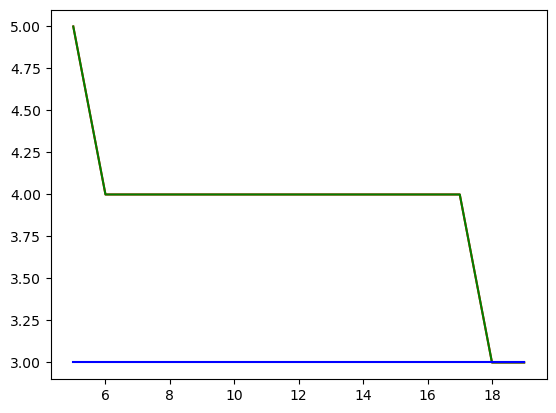

In [33]:
def calculate_density1(k, n):
    return math.ceil(k / (3 - 6/n))

def calculate_density2(k, n):
    return math.floor((k + 3 - 7/n) / (3 - 6/n))

def calculate_density(k):
    return math.ceil((k+1) / 3)

n = list(range(5, 20))
k = 8

y1 = [calculate_density1(k, i) for i in n]
y2 = [calculate_density2(k, i) for i in n]
y3 = [calculate_density(k) for i in n]

plt.plot(n, y1, label='Density 1', color='red')
plt.plot(n, y2, label='Density 2', color='green')
plt.plot(n, y3, label='Density', color='blue')

plt.show()

In [34]:
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [35]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        # Color the nodes and edges
        G.nodes[source]['color'] = 'green'
        for target in targets:
            G.edges[source, target]['color'] = 'blue' if source % embedding_layers_number == 0 else 'red'

        source += 1
    return G

In [55]:
def draw_graph(G: nx.Graph):
    """Draw a graph with node and edge colors.

    Parameters
    ----------
    G : nx.Graph
        The graph to draw.
    """

    node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
    edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
    plt.show()

In [56]:
def load_graph_from_file(file_path: str):
    """Draw a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

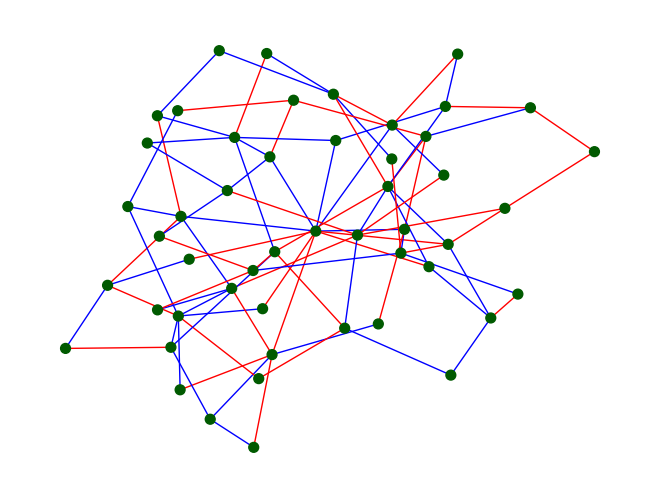

(False, None)


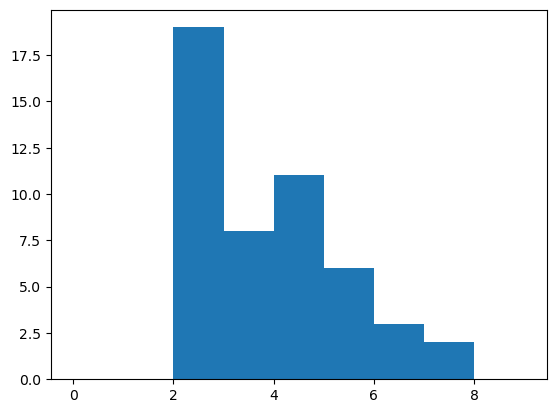

In [75]:
# ba = barabasi_albert_graph(50, 2, 4)
# ba = load_graph_from_file('cmake-build-debug/simple-graph.txt')
ba = load_graph_from_file('cmake-build-debug/graph1-nc.txt')
# ba = load_graph_from_file('cmake-build-debug/graph2-ec.txt')
# ba = load_graph_from_file('cmake-build-debug/graph3-nc-ec.txt')
draw_graph(ba)

degs = [d for n, d in ba.degree()]
plt.figure()
plt.hist(degs, bins=range(10))
print(nx.check_planarity(ba))